## Analyze whether SNWD varies more from year to year or from place to place.

In [17]:
import pandas as pd
import numpy as np
import urllib
import math
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets



Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.1+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


/Users/cui/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['interactive', 'load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [18]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[3]) created by __init__ at <ipython-input-2-fe7e1dcb0c4a>:6 

In [19]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

In [20]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBSSBB'
meas='SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
# df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
420


In [21]:
print df.columns

['coeff_1', 'coeff_2', 'coeff_3', 'elevation', 'label', 'latitude', 'longitude', 'measurement', 'res_1', 'res_2', 'res_3', 'res_mean', 'station', 'total_var', 'undefs', 'vector', 'year']


In [31]:
#extract longitude and latitude for each station
feature='coeff_3'
sqlContext.registerDataFrameAsTable(df,'weather')
#Features=', '.join(['coeff_1', 'coeff_2', 'coeff_3', 'elevation', 'latitude', 'longitude',\
#          'res_1', 'res_2', 'res_3', 'res_mean', 'year'])
Features='station, year, coeff_3'
Query="SELECT %s FROM weather"%Features
print(Query)
pdf = sqlContext.sql(Query).toPandas()
pdf.head()

SELECT station, year, coeff_3 FROM weather


,station,year,coeff_3
0,USC00044176,1965.0,2286.675900
1,USC00049633,1973.0,-1863.413671
2,USC00044176,1953.0,901.552775
3,USC00049632,1967.0,1179.851233
4,USC00049632,1958.0,-207.004981


In [32]:
year_station_table=pdf.pivot(index='year', columns='station', values='coeff_3')
print year_station_table.shape
year_station_table.head(10)

(89, 33)


station,USC00040684,USC00040755,USC00040820,USC00040824,USC00041697,USC00042331,USC00042539,USC00043939,USC00044170,USC00044176,...,USC00049855,USC00260046,USC00260668,USC00261755,USC00262431,USC00263285,USC00265362,USC00268160,USW00023153,USW00023157
year,,,,,,,,,,,,,,,,,,,,,
1913.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,518.016356,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1915.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.620809,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1916.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,587.161854,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1924.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1926.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1927.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1929.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,256.197785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1930.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,533.181161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Estimating the effect of the year vs the effect of the station

To estimate the effect of time vs. location on the first eigenvector coefficient we
compute:

* The average row: `mean-by-station`
* The average column: `mean-by-year`

We then compute the RMS before and after subtracting either  the row or the column vector.

total RMS                   =  1106973.62227
RMS removing mean-by-station=  1038254.48275
Station fraction=  0.0620783893398
RMS removing mean-by-year   =  482709.304796
Year fraction=  0.563937843607


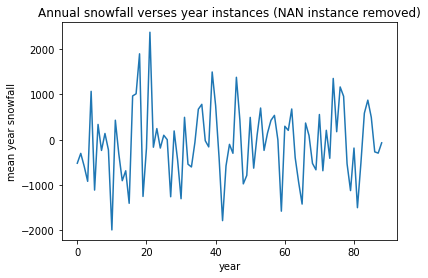

In [33]:
def RMS(Mat):
#     return np.sqrt(np.nanmean(Mat**2))
    return nanmean(Mat**2)


mean_by_year=np.nanmean(year_station_table,axis=1)
plot(-mean_by_year);
xlabel('year')
ylabel('mean year snowfall')
title('Annual snowfall verses year instances (NAN instance removed)')


mean_by_station=np.nanmean(year_station_table,axis=0)
tbl_minus_year = (year_station_table.transpose()-mean_by_year).transpose()
tbl_minus_station = year_station_table-mean_by_station
baseMS = RMS(year_station_table)
stationMS = RMS(tbl_minus_station)
yearMS = RMS(tbl_minus_year)
print 'total RMS                   = ',baseMS
print 'RMS removing mean-by-station= ',stationMS
print 'Station fraction= ', (baseMS - stationMS)/baseMS
print 'RMS removing mean-by-year   = ',yearMS
print 'Year fraction= ', (baseMS - yearMS)/baseMS

In [16]:
T=year_station_table
print 'initial RMS=',RMS(T)
for i in range(5):
    mean_by_year=np.nanmean(T,axis=1)
    T=(T.transpose()-mean_by_year).transpose()
    print i,'after removing mean by year    =',RMS(T)
    mean_by_station=np.nanmean(T,axis=0)
    T=T-mean_by_station
    print i,'after removing mean by stations=',RMS(T)

initial RMS= 11289133.9245
0 after removing mean by year    = 6277212.17392
0 after removing mean by stations= 2887338.88106
1 after removing mean by year    = 2178627.68848
1 after removing mean by stations= 1972025.16913
2 after removing mean by year    = 1900082.35242
2 after removing mean by stations= 1872019.39653
3 after removing mean by year    = 1860061.00095
3 after removing mean by stations= 1854541.0104
4 after removing mean by year    = 1851793.05389
4 after removing mean by stations= 1850327.72145
